<a href="https://colab.research.google.com/github/yosep98/2024S-Ajou-ML/blob/main/HW3_202022349%EB%B0%95%EC%9A%94%EC%85%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import seaborn as sns

In [ ]:
 from google.colab import drive
 drive.mount('/content/drive')

Mounted at /content/drive


# pytorch 기초

pytorch의 장점은 backword를 자체적으로 수행할 수 있다는 것입니다.

아래의 코드는 2차원 데이터로 2차원의 weight와 1개의 bias 계산하는 예제입니다.

- (requires_grad=True) 가 설정된 tensor들은 자동으로 gradiant를 계산하고 저장합니다.

- loss_function을 통해 구해진 값에 대하여 .backword()를 수행하면 gradiant를 계산하게 됩니다.


In [ ]:
import torch

X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

# Initialize weights and bias with requires_grad=True
w = torch.tensor([[0.0], [0.0]], dtype=torch.float32,requires_grad=True)
b = torch.tensor([0.0], dtype=torch.float32, requires_grad=True)
def forward(X):
    return torch.matmul(X, w) + b

def loss(Y, Y_pred):
    return ((Y_pred - Y) ** 2).mean()

learning_rate = 0.01
n_iters = 100

for epoch in range(n_iters):
    Y_pred = forward(X)
    l = loss(Y, Y_pred)

    # gradiant 초기화
    w.grad = None
    b.grad = None

    # backward pass
    l.backward()

    # weights와 bias 업데이트
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {l.item()}')

print("Trained weights:", w)
print("Trained bias:", b)

Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.182020902633667
Epoch 41, Loss: 0.16991257667541504
Epoch 51, Loss: 0.15860998630523682
Epoch 61, Loss: 0.14805902540683746
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.1290162056684494
Epoch 91, Loss: 0.12043382972478867
Trained weights: tensor([[0.8717],
        [0.8450]], requires_grad=True)
Trained bias: tensor([-0.0267], requires_grad=True)


아래의 예시는 위와 동일한 코드이지만, 편하게 사용할 수 있는 함수들입니다.

- 각 대응되는 부분들을 확인해보세요

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Define the data
X = torch.tensor([[1, 2], [2, 3], [3, 4], [4, 5]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

initial_weight = torch.tensor([[0.0, 0.0]], dtype=torch.float32)
initial_bias = torch.tensor([0.0], dtype=torch.float32)


LinearModel = nn.Linear(in_features=2, out_features=1, bias=True)  # linear layer
LinearModel.weight.data = initial_weight.clone() #동일한 결과를 위해 동일하게 초기화
LinearModel.bias.data = initial_bias.clone() #동일한 결과를 위해 동일하게 초기화


criterion = nn.MSELoss() # loss fucntion 정의


optimizer = optim.SGD(LinearModel.parameters(), lr=0.01) # optimizer 정의

# Training loop
n_iters = 100
for epoch in range(n_iters):

    Y_pred = LinearModel(X)


    loss = criterion(Y_pred, Y)

    optimizer.zero_grad() # gradiant 초기화
    loss.backward() # backword process
    optimizer.step() # weight (&bias) update

    if epoch % 10 == 0:
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


trained_weight, trained_bias = LinearModel.weight.data, LinearModel.bias.data
print("Trained weights:", trained_weight)
print("Trained bias:", trained_bias)


Epoch 1, Loss: 30.0
Epoch 11, Loss: 0.20919689536094666
Epoch 21, Loss: 0.19499194622039795
Epoch 31, Loss: 0.18202082812786102
Epoch 41, Loss: 0.16991257667541504
Epoch 51, Loss: 0.15860998630523682
Epoch 61, Loss: 0.1480589509010315
Epoch 71, Loss: 0.13821005821228027
Epoch 81, Loss: 0.12901611626148224
Epoch 91, Loss: 0.12043388187885284
Trained weights: tensor([[0.8717, 0.8450]])
Trained bias: tensor([-0.0267])


#### GPU 사용

- 런타임 > 런타임 유형변경 > GPU 선택
- .to() method를 사용하여 GPU로 모델과 데이터를 올릴 수 있음
- .cuda() 를 사용하는 것도 가능


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LinearModel.to(device) # GPU로 올리기
print(LinearModel)

Linear(in_features=2, out_features=1, bias=True)


In [ ]:
X = X.to(device) # data도 GPU로 올려야 연산 가능함

In [ ]:
LinearModel(X)

tensor([[2.5349],
        [4.2516],
        [5.9683],
        [7.6850]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
LinearModel.cpu() # 다시 CPU로
X.cpu()

tensor([[1., 2.],
        [2., 3.],
        [3., 4.],
        [4., 5.]])

# 문제 1


- MNIST Dataset을 활용하여 손글씨 이미지(숫자)를 예측하는 모델을 만드세요.
- 해당 데이터는 0~9까지의 숫자를 가지고 있습니다.

In [ ]:
# Load training data
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import random_split

MNIST 데이터를 데이터 로더에 넣어서 사용하면 미니 배치 단위로 꺼내 쓸 수 있습니다.

In [ ]:
training_data = datasets.MNIST(
    root="data",
    train=True, # training data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

val_size = 5000
train_size = len(training_data) - val_size
training_data, val_data = random_split(training_data, [train_size, val_size])

# Load test data
test_data = datasets.MNIST(
    root="data",
    train=False, # test data
    download=True,
    transform=v2.ToTensor() # 이미지를 tensor로 변형
)

# data loader
# train, test 각각의 data loader 생성
smaple_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=True)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 59733929.94it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1767888.12it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 22278424.75it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5410544.95it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# train feature와 label을 train_loader로부터 가져오기
sample_features, sample_labels = next(iter(smaple_loader))
print(f"Feature batch shape: {sample_features.size()}")
print(f"Labels batch shape: {sample_labels.size()}")

Feature batch shape: torch.Size([1, 1, 28, 28])
Labels batch shape: torch.Size([1])


#### 이미지로 확인

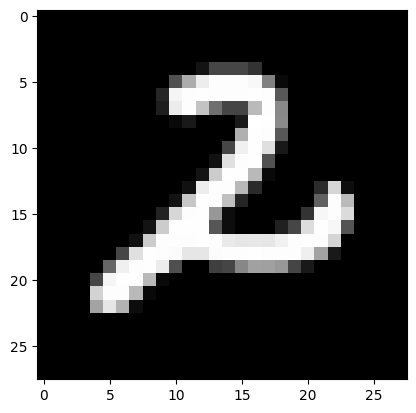

Label: 2


In [ ]:
img = sample_features[0].squeeze()
label = sample_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 문제 1-1

MNIST 데이터셋을 아래의 조건에 따라 학습시키세요.

Fully connected layer (multi layer perceptron)로 NeuralNetwork를 아래의 조건에 맞게 완성하세요.

 - NeuralNetwork 모델 구축
    - 3개의 linear layer와 2개의 ReLU layer를 사용하세요.
    - nn.Linear, nn.ReLU
    - 각 layer의 hidden dimension size는 자유롭게 설정합니다.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten() # 28x28 이미지를 784 픽셀 값의 배열로 변경
        self.linear_relu_stack = nn.Sequential(
            # 3개의 linear layer와 2개의 ReLU layer를 구성하세요
        #===================================================#

            nn.Linear(28*28, 128),  # 첫 번째 선형 계층: 입력 크기 784, 출력 크기 128
            nn.ReLU(),              # ReLU 활성화 함수
            nn.Linear(128, 64),     # 두 번째 선형 계층: 입력 크기 128, 출력 크기 64
            nn.ReLU(),              # ReLU 활성화 함수
            nn.Linear(64, 10)       # 세 번째 선형 계층: 입력 크기 64, 출력 크기 10

        #===================================================#

        )

    def forward(self, x):
        # forward 함수 구현
        #===================================================#
        x = self.flatten(x)          # 입력 이미지 평탄화
        logits = self.linear_relu_stack(x)  # 입력을 선형-Relu 스택에 전달
        #===================================================#
        return logits # forward 결과 저장

## 문제 1-2

위에서 만든 NeuralNetwork 모델을 학습시키세요.
train과 test함수를 만들세요.

- CrossEntropy 사용 (nn.CrossEntropyLoss)
- Epoch : 10, batch size : 32
- validation 정확도 90% 이상

In [ ]:
# hyperparameter 설정
import torch.optim as optim
FcModel = NeuralNetwork()
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(FcModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches

# data loader의 batch size을 16로 변경
train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)

In [ ]:
def train(dataloader , model , loss_fn , optimizer , lr_scheduler=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_, target_) in enumerate(dataloader):

        #===================================================#
        # 데이터와 타겟을 디바이스로 이동
        data_, target_ = data_.to(device), target_.to(device)
        # 예측과 손실 계산
        pred = model(data_)
        loss = loss_fn(pred, target_)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 정확도와 손실 집계
        epoch_loss += loss.item()
        epoch_correct += (pred.argmax(1) == target_).type(torch.float).sum().item()
        #===================================================#

    if lr_scheduler != None:
        lr_scheduler.step()

    return epoch_correct/size , epoch_loss / num_batches

In [ ]:
def test(dataloader , model , loss_fn):
    size = len(dataloader.dataset)
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0
    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_, target_) in enumerate(dataloader):

            #========================================#
            # 데이터와 타겟을 디바이스로 이동
            data_, target_ = data_.to(device), target_.to(device)

            # 예측과 손실 계산
            pred = model(data_)
            loss = loss_fn(pred, target_)

            # 정확도와 손실 집계
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == target_).type(torch.float).sum().item()
            #========================================#

    return epoch_correct/size  , epoch_loss / num_baches

In [ ]:
FcModel.cuda()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
# 체크포인트 디렉토리가 존재하지 않으면 생성
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

best_loss = np.inf
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   FcModel ,
                                   criterion ,
                                   optimizer )

    val_acc , val_loss = test(val_loader , FcModel , criterion)


    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict(), "checkpoints/NN_best.pth")


 10%|█         | 1/10 [00:11<01:43, 11.45s/it]

epoch:0     train_loss = 1.1922 , train_acc:0.6781     val_loss = 0.4715 , val_acc:0.8730     learning rate: 0.001


 20%|██        | 2/10 [00:22<01:29, 11.13s/it]

epoch:1     train_loss = 0.3916 , train_acc:0.8887     val_loss = 0.3433 , val_acc:0.9024     learning rate: 0.001


 30%|███       | 3/10 [00:33<01:16, 10.97s/it]

epoch:2     train_loss = 0.3203 , train_acc:0.9071     val_loss = 0.3000 , val_acc:0.9170     learning rate: 0.001


 40%|████      | 4/10 [00:44<01:05, 10.96s/it]

epoch:3     train_loss = 0.2825 , train_acc:0.9179     val_loss = 0.2690 , val_acc:0.9246     learning rate: 0.001


 50%|█████     | 5/10 [00:55<00:54, 10.96s/it]

epoch:4     train_loss = 0.2539 , train_acc:0.9267     val_loss = 0.2506 , val_acc:0.9298     learning rate: 0.001


 60%|██████    | 6/10 [01:05<00:43, 10.96s/it]

epoch:5     train_loss = 0.2287 , train_acc:0.9338     val_loss = 0.2258 , val_acc:0.9358     learning rate: 0.001


 70%|███████   | 7/10 [01:16<00:32, 10.94s/it]

epoch:6     train_loss = 0.2078 , train_acc:0.9406     val_loss = 0.2088 , val_acc:0.9408     learning rate: 0.001


 80%|████████  | 8/10 [01:27<00:21, 10.95s/it]

epoch:7     train_loss = 0.1901 , train_acc:0.9454     val_loss = 0.1949 , val_acc:0.9412     learning rate: 0.001


 90%|█████████ | 9/10 [01:38<00:10, 10.99s/it]

epoch:8     train_loss = 0.1743 , train_acc:0.9499     val_loss = 0.1832 , val_acc:0.9448     learning rate: 0.001


100%|██████████| 10/10 [01:49<00:00, 10.99s/it]

epoch:9     train_loss = 0.1601 , train_acc:0.9531     val_loss = 0.1704 , val_acc:0.9506     learning rate: 0.001


# 문제 1-3 : CNN

- CNN 모델을 아래의 조건과 같이 구축하여 학습하시오.
- validation 정확도 90% 이상

아래의 조건을 만족하는 CNN model을 만드시오.


 - CNN layer 1 - filter 수 32, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 2 - filter 수 64, filter size : 3,
 - Max pooling : 2 x 2
 - CNN layer 3 - filter 수 128, filter size : 3,
 - Max pooling : 2 x 2
 - Fc layer 1 : last Cnn feature size (flatten) -> 128
 - ReLU ()
 - Fc layer 2 : 128 -> 64
 - ReLU ()
 - Fc layer 3 : 64 -> 10

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
 def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)#레이어1
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)# 풀링
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)#레이어2
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)#레이어3
        self.flatten = nn.Flatten()#flatten
        self.fc1 = nn.Linear(128 * 1 * 1, 128)#fc1
        self.fc2 = nn.Linear(128, 64)#fc2
        self.fc3 = nn.Linear(64, 10)#fc3

 def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))# 입력 데이터에 첫 번째 합성곱 -> ReLU 활성화 -> 최대 풀링
        x = self.pool(F.relu(self.conv2(x)))# 두 번째 합성곱 -> ReLU 활성화 -> 최대 풀링
        x = self.pool(F.relu(self.conv3(x)))# 세 번째 합성곱 -> ReLU 활성화 -> 최대 풀링
        x = self.flatten(x)# 텐서를 평탄화하여 1차원 벡터로 변환
        x = F.relu(self.fc1(x))# 첫 번째 완전 연결 레이어 -> ReLU 활성화
        x = F.relu(self.fc2(x)) # 두 번째 완전 연결 레이어 -> ReLU 활성화
        x = self.fc3(x)# 세 번째 완전 연결 레이어
        return x

In [ ]:
# hyperparameter 설정
import torch.optim as optim
SimModel = SimpleCNN()
SimModel.to(device)
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(SimModel.parameters(), lr=0.001, momentum=0.9) # optimizer

EPOCHS = 10 # the number of epochs
n_batch = 32 # the number of batches


train_loader = torch.utils.data.DataLoader(training_data, batch_size=n_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=n_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_batch, shuffle=True)

Feature batch shape: torch.Size([32, 1, 28, 28])


NameError: name 'output' is not defined

In [ ]:
# 체크포인트 디렉토리가 존재하지 않으면 생성
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   SimModel ,
                                   criterion ,
                                   optimizer )

    val_acc , val_loss = test(val_loader , SimModel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')


    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(FcModel.state_dict() , "checkpoints/Simple_CNN_best.pth")


 10%|█         | 1/10 [00:14<02:06, 14.08s/it]

epoch:0     train_loss = 2.2849 , train_acc:0.1651     val_loss = 2.2082 , val_acc:0.3614     learning rate: 0.001


 20%|██        | 2/10 [00:27<01:47, 13.47s/it]

epoch:1     train_loss = 0.8954 , train_acc:0.7347     val_loss = 0.3549 , val_acc:0.8916     learning rate: 0.001


 30%|███       | 3/10 [00:40<01:33, 13.36s/it]

epoch:2     train_loss = 0.2364 , train_acc:0.9290     val_loss = 0.1689 , val_acc:0.9482     learning rate: 0.001


 40%|████      | 4/10 [00:53<01:19, 13.26s/it]

epoch:3     train_loss = 0.1518 , train_acc:0.9535     val_loss = 0.1343 , val_acc:0.9598     learning rate: 0.001


 50%|█████     | 5/10 [01:06<01:06, 13.24s/it]

epoch:4     train_loss = 0.1209 , train_acc:0.9631     val_loss = 0.0992 , val_acc:0.9690     learning rate: 0.001


 60%|██████    | 6/10 [01:19<00:52, 13.24s/it]

epoch:5     train_loss = 0.1019 , train_acc:0.9693     val_loss = 0.0908 , val_acc:0.9730     learning rate: 0.001


 70%|███████   | 7/10 [01:33<00:39, 13.20s/it]

epoch:6     train_loss = 0.0885 , train_acc:0.9732     val_loss = 0.0852 , val_acc:0.9718     learning rate: 0.001


 80%|████████  | 8/10 [01:46<00:26, 13.24s/it]

epoch:7     train_loss = 0.0800 , train_acc:0.9757     val_loss = 0.0828 , val_acc:0.9746     learning rate: 0.001


 90%|█████████ | 9/10 [01:59<00:13, 13.19s/it]

epoch:8     train_loss = 0.0711 , train_acc:0.9784     val_loss = 0.0949 , val_acc:0.9698     learning rate: 0.001


100%|██████████| 10/10 [02:12<00:00, 13.22s/it]

epoch:9     train_loss = 0.0650 , train_acc:0.9798     val_loss = 0.0750 , val_acc:0.9740     learning rate: 0.001


# Smoke image dataset


- 본 데이터셋은 흡연자의 모습과 비흡자의 모습이 담긴 이미지 파일입니다.
- 이미지 파일을 python으로 가져오기 위해서 다음 과정을 수행합니다.



1.   이미지가 있는 file path를 pandas DataFrame에 label과 함께 저장
2.   데이터 로드를 효율적으로 하기 위해서, 학습 배치마다 해당 path의 이미지를 불러옴



In [ ]:
from PIL import Image
from glob import glob

In [ ]:
data_path = '/content/drive/MyDrive/smoke'

In [ ]:
import pandas as pd
import os
from glob import glob

def create_dataframe(data_path, label_list, data_type):
    df = pd.DataFrame({"path": [], "label": [], "class_id": []})
    img_list = glob(os.path.join(data_path, '*.jpg'))

    for img in img_list:
        file_name = os.path.splitext(img)[0].split("/")[-1]
        if file_name[0:len(label_list[0])] == label_list[0]:
            new_data =pd.DataFrame({"path":img,"label":label_list[0], "class_id":0}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)
        elif file_name[0:len(label_list[1])] == label_list[1]:
            new_data =pd.DataFrame({"path":img,"label":label_list[1], "class_id":1}, index=[1])
            df = pd.concat([df, new_data], ignore_index=True)

    df[["path"]] = df[["path"]].astype(str)
    df[["label"]] = df[["label"]].astype(str)
    df[["class_id"]] = df[["class_id"]].astype(int)

    return df

In [ ]:
# Example usage:
train_path = '/content/drive/MyDrive/smoke/Training/Training'
valid_path = '/content/drive/MyDrive/smoke/Validation/Validation'
test_path = '/content/drive/MyDrive/smoke/Testing/Testing'
label_list = ['notsmoking', 'smoking']

train_df = create_dataframe(train_path, label_list, 'training')
val_df = create_dataframe(valid_path, label_list, 'validation')
test_df = create_dataframe(test_path, label_list, 'test')

In [ ]:
print(f"train_data: {len(train_df)}")
print(f"val_data:{len(val_df)}")
print(f"test_data:{len(test_df)}")

train_data: 716
val_data:180
test_data:224


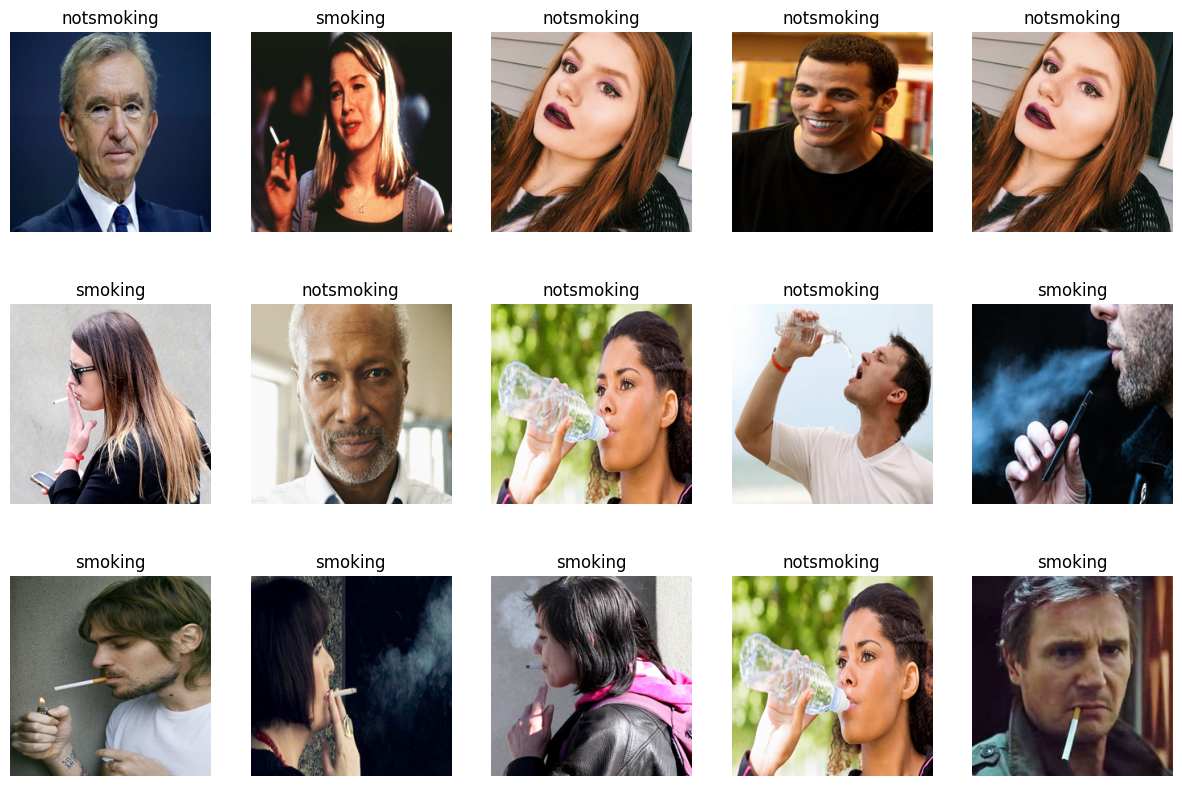

In [ ]:
show_imgs = 15
idx = np.random.randint(0,len(val_df) , size = show_imgs)
fig , axes = plt.subplots(show_imgs // 5 , 5 , figsize = (15 , 10))
axes = axes.flatten()
for i , ax in enumerate(axes):
    full_path = val_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.loc[idx[i]]['label'])
    ax.set_axis_off()

## Dataset & Dataloader

Pytorch의 Dataset & Dataloader은, 데이터를 다루고 모델을 훈련 및 시험하기 위하여 가장 주의를 기울여야 될 부분 중의 하나입니다.

Dataset은 전체 데이터에서 특정 데이터를 꺼내오는 역할 및 전처리나 augmentation, 추가적인 function 처리를 효율적으로 할 수 있도록 합니다.
Dataloader의 경우, Dataset을 Minibatch 형태로 만들어 주며, Batch size나, Shuffle 여부에 대한 것들을 설정할 수 있습니다.

자세한 사항은 아래의 링크를 확인해보시기 바랍니다.

- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [ ]:
from torch.utils.data import Dataset , DataLoader
from torchvision import datasets
from torchvision.transforms import v2

In [ ]:
class BaseDataset(torch.utils.data.Dataset):
    def __init__(self , dataframe , transforms_):
        self.df = dataframe
        self.transforms_ = transforms_

    def __len__(self):
        return len(self.df)

    def __getitem__(self ,index):
        img_path = self.df.iloc[index]['path']
        img = Image.open(img_path).convert("RGB")
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img , class_id

In [ ]:
SimpleTransforms = v2.Compose([
    v2.Resize((224,224)), # image 크기 맞추기
    v2.PILToTensor(), # torch.tensor로 변환
    v2.ToDtype(torch.float32),#float32 타입변환
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]) #정규화

In [ ]:
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
example_dataset = BaseDataset(train_df , SimpleTransforms) # train_transforms
example_loader = DataLoader(example_dataset , batch_size=BATCH_SIZE , shuffle = True)

In [ ]:
img, class_id = next(iter(example_dataset))

In [ ]:
img.shape # (batch, channel, W, H)

torch.Size([3, 224, 224])

In [ ]:
img, class_id = next(iter(example_loader))

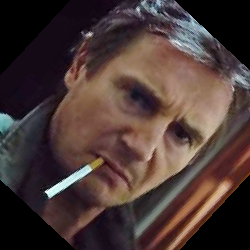

In [ ]:
# augmentation 참고
# https://pytorch.org/vision/main/transforms.html

rotation_transform = v2.RandomRotation(degrees=90) # compose에 추가 가능
image = Image.open(full_path)
rotated_image = rotation_transform(image)
rotated_image


# 문제 2

 1-1의 모델을 **layer를 추가하지 않고**, 아래의 조건을 토대로 성능을
 향상시켜보세요.


 - batch norm, dropout 둘 다 적용
 - data augmentation 기법 1가지 이상 추가
 - layer 자체를 추가하는 것 이외의 다른 방법들 추가 적용 가능
    - kernel size 등등
    - max pooling은 layer로 취급하지 않음
    - 이외 추가적인 hyperparameter 변경 가능
    - feature size 당연히, 수정 가능
 - **test acc (75%) 이상 달성**

In [ ]:
CustomTransforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

In [ ]:
#get dataloader

train_dataset = BaseDataset(train_df , CustomTransforms) # train_transforms
val_dataset = BaseDataset(val_df , CustomTransforms)
test_dataset = BaseDataset(test_df , CustomTransforms)
train_loader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle = True)
val_loader = DataLoader(val_dataset , batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset , batch_size=BATCH_SIZE)

In [ ]:
# 데이터셋 및 데이터로더 생성
BATCH_SIZE = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = BaseDataset(train_df, CustomTransforms)
val_dataset = BaseDataset(val_df, CustomTransforms)
test_dataset = BaseDataset(test_df, CustomTransforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(32)# 배치놈 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)# 배치놈 추가
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(128)# 배치놈 추가
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 26 * 26, 128)
        self.dropout1 = nn.Dropout(0.5)  # 드롭아웃 추가
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)  # 드롭아웃 추가
        self.fc3 = nn.Linear(64, 1)  # BCELoss 사용 시 출력 노드 수를 1로 설정

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))  # 시그모이드 활성화 함수 추가
        return x

In [ ]:
ImpModel = ImprovedCNN().to(device)
ImpModel.cuda()

ImprovedCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=86528, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
print(ImpModel(torch.randn((16, 3, 224, 224)).to(device)).shape)#이미지 모델출력 사이즈확인

torch.Size([16, 1])


In [ ]:
def train(dataloader, ImpModel, loss_fn, optimizer, lr_scheduler=None):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    ImpModel.train()
    epoch_loss, epoch_correct = 0, 0

    for data_, target_ in dataloader:
        # 데이터를 장치로 이동
        data_, target_ = data_.to(device), target_.to(device)
        # 타겟을 float 타입으로 변환 (BCELoss 사용 시 필요)
        target_ = target_.float().view(-1, 1)  # BCELoss 사용 시 타겟의 shape을 [batch_size, 1]로 맞춤
        # 예측과 손실 계산
        pred = ImpModel(data_)
        loss = loss_fn(pred, target_)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 정확도와 손실 집계
        epoch_loss += loss.item()
        epoch_correct += (pred.argmax(1) == target_).type(torch.float).sum().item()

    if lr_scheduler is not None:
        lr_scheduler.step()

    epoch_accuracy = epoch_correct / size
    avg_loss = epoch_loss / len(dataloader)
    return epoch_accuracy, avg_loss


def test(dataloader, ImpModel, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    epoch_loss, epoch_correct = 0, 0


    with torch.no_grad():  # 기울기 계산 비활성화
        for data_, target_ in dataloader:
            # 데이터를 장치로 이동
            data_, target_ = data_.to(device), target_.to(device)
            # 타겟을 float 타입으로 변환 (BCELoss 사용 시 필요)
            target_ = target_.float().view(-1, 1)  # BCELoss 사용 시 타겟의 shape을 [batch_size, 1]로 맞춤

            # 예측과 손실 계산
            pred = ImpModel(data_)
            loss = loss_fn(pred, target_)
            # 정확도와 손실 집계
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == target_).type(torch.float).sum().item()

    epoch_accuracy = epoch_correct / size
    avg_loss = epoch_loss / len(dataloader)
    return epoch_accuracy, avg_loss

In [ ]:
EPOCHS = 100
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.BCELoss()

# hyperparameter 추가 및 변경 가능 설정해보세요
# optimizer, lr_scheduler 변경 가능
#==============================#
Cosine_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)# lr_scheduler 변경
optimizer = optim.Adam(ImpModel.parameters(), lr=0.001)# optimizer 변경
#==============================#

patience = 10
counter = 0
best_loss = np.inf

In [ ]:
best_loss = float('inf')
counter = 0
# 체크포인트 디렉토리 생성
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader, ImpModel, criterion, optimizer, Cosine_lr_scheduler)
    val_acc, val_loss = test(val_loader, ImpModel, criterion)

    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f}, train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f}, val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(ImpModel.state_dict() , "checkpoints/Improved_CNN_best.pth")
    else:
        counter+=1
    if counter >= patience:
        test_acc , val_loss = test(test_loader , ImpModel , criterion)
        print("Early stop !")
        print(test_acc)
        break

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  1%|          | 1/100 [03:04<5:04:38, 184.63s/it]

epoch:0     train_loss = 9.8607, train_acc:7.9609     val_loss = 5.5211, val_acc:7.9333     learning rate: 0.001


  2%|▏         | 2/100 [03:10<2:09:45, 79.44s/it] 

epoch:1     train_loss = 2.1434, train_acc:7.9832     val_loss = 0.8502, val_acc:7.9333     learning rate: 0.001


  3%|▎         | 3/100 [03:16<1:14:09, 45.88s/it]

epoch:2     train_loss = 0.7338, train_acc:7.9888     val_loss = 0.6471, val_acc:7.9333     learning rate: 0.001


  4%|▍         | 4/100 [03:22<48:05, 30.05s/it]  

epoch:3     train_loss = 0.6702, train_acc:7.9609     val_loss = 0.6499, val_acc:7.9333     learning rate: 0.001


  5%|▌         | 5/100 [03:27<33:44, 21.31s/it]

epoch:4     train_loss = 0.6491, train_acc:7.9553     val_loss = 0.6837, val_acc:7.9333     learning rate: 0.001


  6%|▌         | 6/100 [03:34<25:14, 16.12s/it]

epoch:5     train_loss = 0.6192, train_acc:7.9665     val_loss = 0.7672, val_acc:7.9333     learning rate: 0.001


  7%|▋         | 7/100 [03:40<20:02, 12.93s/it]

epoch:6     train_loss = 0.6387, train_acc:7.9609     val_loss = 0.6398, val_acc:7.9333     learning rate: 0.001


  8%|▊         | 8/100 [03:46<16:25, 10.71s/it]

epoch:7     train_loss = 0.6410, train_acc:7.9721     val_loss = 0.6654, val_acc:7.9333     learning rate: 0.001


  9%|▉         | 9/100 [03:52<14:02,  9.25s/it]

epoch:8     train_loss = 0.6527, train_acc:7.9777     val_loss = 0.6369, val_acc:7.9333     learning rate: 0.001


 10%|█         | 10/100 [03:58<12:14,  8.16s/it]

epoch:9     train_loss = 0.6220, train_acc:7.9665     val_loss = 0.6529, val_acc:7.9333     learning rate: 0.001


 11%|█         | 11/100 [04:04<11:05,  7.47s/it]

epoch:10     train_loss = 0.6441, train_acc:7.9721     val_loss = 0.6405, val_acc:7.9333     learning rate: 0.001


 12%|█▏        | 12/100 [04:09<10:16,  7.01s/it]

epoch:11     train_loss = 0.6328, train_acc:7.9721     val_loss = 0.7104, val_acc:7.9333     learning rate: 0.001


 13%|█▎        | 13/100 [04:16<09:49,  6.77s/it]

epoch:12     train_loss = 0.6348, train_acc:7.9441     val_loss = 0.6156, val_acc:7.9333     learning rate: 0.001


 14%|█▍        | 14/100 [04:22<09:19,  6.51s/it]

epoch:13     train_loss = 0.6139, train_acc:7.9665     val_loss = 0.6361, val_acc:7.9333     learning rate: 0.001


 15%|█▌        | 15/100 [04:28<08:58,  6.33s/it]

epoch:14     train_loss = 0.6063, train_acc:7.9777     val_loss = 0.6395, val_acc:7.9333     learning rate: 0.001


 16%|█▌        | 16/100 [04:33<08:36,  6.15s/it]

epoch:15     train_loss = 0.6062, train_acc:7.9777     val_loss = 0.6452, val_acc:7.9333     learning rate: 0.001


 17%|█▋        | 17/100 [04:39<08:24,  6.08s/it]

epoch:16     train_loss = 0.6026, train_acc:7.9609     val_loss = 0.6885, val_acc:7.9333     learning rate: 0.001


 18%|█▊        | 18/100 [04:45<08:14,  6.03s/it]

epoch:17     train_loss = 0.5877, train_acc:7.9777     val_loss = 0.7198, val_acc:7.9333     learning rate: 0.001


 19%|█▉        | 19/100 [04:51<08:03,  5.97s/it]

epoch:18     train_loss = 0.6139, train_acc:7.9665     val_loss = 0.6140, val_acc:7.9333     learning rate: 0.001


 20%|██        | 20/100 [04:57<07:54,  5.94s/it]

epoch:19     train_loss = 0.6008, train_acc:7.9721     val_loss = 0.7104, val_acc:7.9333     learning rate: 0.001


 21%|██        | 21/100 [05:03<07:48,  5.92s/it]

epoch:20     train_loss = 0.6014, train_acc:7.9553     val_loss = 0.6005, val_acc:7.9333     learning rate: 0.001


 22%|██▏       | 22/100 [05:09<07:40,  5.91s/it]

epoch:21     train_loss = 0.5999, train_acc:7.9721     val_loss = 0.6289, val_acc:7.9333     learning rate: 0.001


 23%|██▎       | 23/100 [05:14<07:34,  5.90s/it]

epoch:22     train_loss = 0.5613, train_acc:7.9553     val_loss = 0.8292, val_acc:7.9333     learning rate: 0.001


 24%|██▍       | 24/100 [05:20<07:27,  5.89s/it]

epoch:23     train_loss = 0.6032, train_acc:7.9777     val_loss = 0.6372, val_acc:7.9333     learning rate: 0.001


 25%|██▌       | 25/100 [05:26<07:16,  5.82s/it]

epoch:24     train_loss = 0.5673, train_acc:7.9721     val_loss = 0.6990, val_acc:7.9333     learning rate: 0.001


 26%|██▌       | 26/100 [05:32<07:12,  5.85s/it]

epoch:25     train_loss = 0.5508, train_acc:7.9553     val_loss = 0.6379, val_acc:7.9333     learning rate: 0.001


 27%|██▋       | 27/100 [05:37<06:59,  5.75s/it]

epoch:26     train_loss = 0.5338, train_acc:7.9497     val_loss = 0.6056, val_acc:7.9333     learning rate: 0.001


 28%|██▊       | 28/100 [05:43<06:57,  5.80s/it]

epoch:27     train_loss = 0.5251, train_acc:7.9553     val_loss = 0.6973, val_acc:7.9333     learning rate: 0.001


 29%|██▉       | 29/100 [05:49<06:48,  5.75s/it]

epoch:28     train_loss = 0.5233, train_acc:7.9553     val_loss = 0.7516, val_acc:7.9333     learning rate: 0.001


 30%|███       | 30/100 [05:55<06:47,  5.82s/it]

epoch:29     train_loss = 0.5636, train_acc:7.9777     val_loss = 0.7934, val_acc:7.9333     learning rate: 0.001


 31%|███       | 31/100 [06:01<06:45,  5.87s/it]

epoch:30     train_loss = 0.5501, train_acc:7.9721     val_loss = 0.5840, val_acc:7.9333     learning rate: 0.001


 32%|███▏      | 32/100 [06:07<06:48,  6.00s/it]

epoch:31     train_loss = 0.5224, train_acc:7.9721     val_loss = 0.5818, val_acc:7.9333     learning rate: 0.001


 33%|███▎      | 33/100 [06:13<06:39,  5.96s/it]

epoch:32     train_loss = 0.5389, train_acc:7.9721     val_loss = 0.5814, val_acc:7.9333     learning rate: 0.001


 34%|███▍      | 34/100 [06:19<06:38,  6.04s/it]

epoch:33     train_loss = 0.5156, train_acc:7.9665     val_loss = 0.6737, val_acc:7.9333     learning rate: 0.001


 35%|███▌      | 35/100 [06:25<06:26,  5.94s/it]

epoch:34     train_loss = 0.5037, train_acc:7.9665     val_loss = 0.7131, val_acc:7.9333     learning rate: 0.001


 36%|███▌      | 36/100 [06:31<06:20,  5.94s/it]

epoch:35     train_loss = 0.5079, train_acc:7.9665     val_loss = 0.5645, val_acc:7.9333     learning rate: 0.001


 37%|███▋      | 37/100 [06:37<06:16,  5.97s/it]

epoch:36     train_loss = 0.5724, train_acc:7.9832     val_loss = 0.6298, val_acc:7.9333     learning rate: 0.001


 38%|███▊      | 38/100 [06:43<06:06,  5.91s/it]

epoch:37     train_loss = 0.5341, train_acc:7.9609     val_loss = 0.6891, val_acc:7.9333     learning rate: 0.001


 39%|███▉      | 39/100 [06:49<05:58,  5.87s/it]

epoch:38     train_loss = 0.5477, train_acc:7.9441     val_loss = 0.6791, val_acc:7.9333     learning rate: 0.001


 40%|████      | 40/100 [06:54<05:53,  5.89s/it]

epoch:39     train_loss = 0.5244, train_acc:7.9553     val_loss = 0.7089, val_acc:7.9333     learning rate: 0.001


 41%|████      | 41/100 [07:00<05:46,  5.88s/it]

epoch:40     train_loss = 0.5046, train_acc:7.9609     val_loss = 0.5967, val_acc:7.9333     learning rate: 0.001


 42%|████▏     | 42/100 [07:06<05:41,  5.90s/it]

epoch:41     train_loss = 0.4941, train_acc:7.9609     val_loss = 1.1178, val_acc:7.9333     learning rate: 0.001


 43%|████▎     | 43/100 [07:12<05:34,  5.87s/it]

epoch:42     train_loss = 0.5088, train_acc:7.9832     val_loss = 0.6581, val_acc:7.9333     learning rate: 0.001


 44%|████▍     | 44/100 [07:18<05:26,  5.83s/it]

epoch:43     train_loss = 0.4904, train_acc:7.9777     val_loss = 0.6175, val_acc:7.9333     learning rate: 0.001


 45%|████▌     | 45/100 [07:24<05:20,  5.83s/it]

epoch:44     train_loss = 0.4735, train_acc:7.9777     val_loss = 0.6176, val_acc:7.9333     learning rate: 0.001
epoch:45     train_loss = 0.4920, train_acc:7.9944     val_loss = 0.6700, val_acc:7.9333     learning rate: 0.001


 45%|████▌     | 45/100 [08:28<10:22, 11.31s/it]

Early stop !
8.0


torch.Size([])

# 문제 3: Pretrained model
사전 학습된 모델(Pretrained model)을 통해 위의 이미지 데이터를  흡연 여부를 판별고자 합니다.

이를 위해서 모델을 불러오고, 학습 및 검증하여 최종 성능을 평가하시오.

In [ ]:
# pretrained 관련
import torch
import torchvision.transforms as v2
from torchvision import models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 문제 3-1: Pretrained Model (backborn)모델 학습

아래의 `resnet18` 예제를 참고하여, `vgg16`의 pretrained model를 불러와 Smoke 탐지를 진행할 수 있도록 layer를 수정하시오.

- MyVGG16 Class를 완성하시오.
- Vgg16의 CNN layer들은 모두 frozen하시오.
- 추가적인 layer와 다양한 기법들을 추가해도 됩니다.
- **test acc (75%) 이상 달성**
- **(extra) test acc (80%) 이상 달성시 추가 점수(+1): freeze한 layer fine-tuning 가능**


- https://pytorch.org/vision/stable/models.html 참고

In [ ]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [ ]:
print(resnet18) # 각 레이어의 구성을 확인

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
Last_layer_hiddensize = resnet18.fc.in_features
resnet18.fc = nn.Linear(Last_layer_hiddensize, 1)

In [ ]:
myvgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 192MB/s]


In [ ]:
# nn.Linear(10,10).requires_grad = False # gradiant 끄기
# nn.Linear(10,10).requires_grad = True # gradiant 켜기

In [ ]:
import torch.nn as nn
class MyVGG16(nn.Module):
    def __init__(self, pretrained_model):
        super(MyVGG16, self).__init__()
         # 사전 학습된 VGG16 백본
        self.backbone = pretrained_model.features

        # 백본의 모든 레이어 동결 (학습하지 않도록 설정)
        for param in self.backbone.parameters():
            param.requires_grad = False

         # AdaptiveAvgPool2d 및 Flatten 추가
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.flatten = nn.Flatten()

         # smoke 탐지 작업에 맞게 classifier 수정
        # 이진 분류 (smoke vs no smoke)를 가정
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.backbone(x) # 백본을 통해 입력 데이터 처리
        x = self.avgpool(x)# Adaptive Average Pooling 적용
        x = self.flatten(x)# 텐서를 평탄화하여 1차원 벡터로 변환
        x = self.classifier(x)# 수정된 classifier를 통해 분류
        return x

# Load pretrained VGG16 model
pretrained_vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)# 사전 학습된 VGG16 모델 로드
myvgg16 = MyVGG16(pretrained_vgg16)# 사전 학습된 VGG16 모델을 인자로 전달하여 MyVGG16 인스턴스 생성

## 문제 3-2: Fine-tuning

- `MyVGG16`를 활용하여 Fine-tuning을 진행하시오.

In [ ]:
# 하이퍼파라미터 설정
EPOCHS = 100
logs = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

# 체크포인트 디렉토리 생성
if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')

criterion = nn.BCELoss() # 이진 분류를 위한 손실 함수 (Binary Cross Entropy Loss)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, myvgg16.parameters()), lr=0.001)# 학습 가능한 파라미터만 포함한 Adam 옵티마이저
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # 학습률 스케줄러, 매 7 epoch마다 학습률을 0.1배 감소

# Early stopping 설정
patience = 10
counter = 0
best_loss = np.inf
# 학습 및 평가 루프
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")# GPU가 사용 가능하면 GPU를 사용
myvgg16.to(device)# 모델을 설정된 장치(device)로 이동

MyVGG16(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [ ]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.train()# 모델을 학습 모드로 설정
    epoch_loss, epoch_correct = 0, 0

    for i, (data_, target_) in enumerate(dataloader):
        data_, target_ = data_.to(device), target_.to(device).float()# 데이터를 장치로 이동하고, 타겟을 float로 변환

        # Forward pass
        output = model(data_).squeeze() # 모델에 데이터를 전달하여 출력을 얻음
        loss = loss_fn(output, target_)# 손실 계산

        # Backward pass and optimization
        optimizer.zero_grad()# 옵티마이저의 기울기 초기화
        loss.backward()# 백 프로파 를 통해 기울기 계산
        optimizer.step()# 옵티마이저를 통해 파라미터 업데이트

        # Accumulate loss and correct predictions
        epoch_loss += loss.item() * data_.size(0)# 배치 손실을 누적
        predicted = (output > 0.5).float()# 예측 결과를 0.5 기준으로 이진 분류
        epoch_correct += (predicted == target_).sum().item()# 정확한 예측의 개수를 누적

    train_acc = epoch_correct / size# 학습 정확도 계산
    lr_scheduler.step()# 학습률 스케줄러 업데이트

    return train_acc, epoch_loss / num_batches# 학습 정확도와 평균 손실 반환


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    epoch_loss, epoch_correct = 0, 0

    with torch.no_grad():
        model.eval()
        for i, (data_, target_) in enumerate(dataloader):
            data_, target_ = data_.to(device), target_.to(device).float()# 데이터를 장치로 이동하고, 타겟을 float로 변환


            output = model(data_).squeeze()# 모델에 데이터를 전달하여 출력을 얻음
            loss = loss_fn(output, target_)# 모델에 데이터를 전달하여 출력을 얻음


            epoch_loss += loss.item() * data_.size(0)# 배치 손실을 누적
            predicted = (output > 0.5).float()# 예측 결과를 0.5 기준으로 이진 분류
            epoch_correct += (predicted == target_).sum().item()# 정확한 예측의 개수를 누적

    test_acc = epoch_correct / size# 테스트 정확도 계산

    return test_acc, epoch_loss / num_batches# 테스트 정확도와 평균 손실 반환

In [ ]:
myvgg16.cuda()
myvgg16.to(device)

MyVGG16(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader,
                                  myvgg16,
                                  criterion,
                                  optimizer,
                                  Cosine_lr_scheduler)

    val_acc, val_loss = test(val_loader, myvgg16, criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f}, train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f}, val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(myvgg16.state_dict(), "checkpoints/myvgg_16_best.pth")
    else:
        counter += 1

    if counter >= patience:
        test_acc, test_loss = test(test_loader, myvgg16, criterion)
        print("Early stop!")
        print(test_acc)
        break


  0%|          | 0/100 [00:00<?, ?it/s]

epoch:0     train_loss = 778.9543, train_acc:0.5042     val_loss = 750.0000, val_acc:0.5000     learning rate: 0.001


  2%|▏         | 2/100 [00:13<10:57,  6.71s/it]

epoch:1     train_loss = 795.5556, train_acc:0.5000     val_loss = 750.0000, val_acc:0.5000     learning rate: 0.001


  3%|▎         | 3/100 [00:21<11:28,  7.10s/it]

epoch:2     train_loss = 795.5556, train_acc:0.5000     val_loss = 750.0000, val_acc:0.5000     learning rate: 0.001


  4%|▍         | 4/100 [00:27<10:47,  6.75s/it]

epoch:3     train_loss = 795.5556, train_acc:0.5000     val_loss = 750.0000, val_acc:0.5000     learning rate: 0.001


  5%|▌         | 5/100 [00:33<10:26,  6.60s/it]

epoch:4     train_loss = 795.5556, train_acc:0.5000     val_loss = 750.0000, val_acc:0.5000     learning rate: 0.001


  6%|▌         | 6/100 [00:39<10:04,  6.43s/it]

epoch:5     train_loss = 795.5556, train_acc:0.5000     val_loss = 750.0000, val_acc:0.5000     learning rate: 0.001


  7%|▋         | 7/100 [00:46<09:55,  6.40s/it]

epoch:6     train_loss = 795.5556, train_acc:0.5000     val_loss = 750.0000, val_acc:0.5000     learning rate: 0.001


  8%|▊         | 8/100 [00:52<09:43,  6.34s/it]

epoch:7     train_loss = 795.5556, train_acc:0.5000     val_loss = 750.0000, val_acc:0.5000     learning rate: 0.001


  9%|▉         | 9/100 [00:58<09:36,  6.34s/it]

epoch:8     train_loss = 795.5556, train_acc:0.5000     val_loss = 750.0000, val_acc:0.5000     learning rate: 0.001


 10%|█         | 10/100 [01:05<09:30,  6.34s/it]

epoch:9     train_loss = 795.5556, train_acc:0.5000     val_loss = 750.0000, val_acc:0.5000     learning rate: 0.001
epoch:10     train_loss = 795.5556, train_acc:0.5000     val_loss = 750.0000, val_acc:0.5000     learning rate: 0.001


 10%|█         | 10/100 [01:12<10:54,  7.27s/it]

Early stop!
0.5


# 문제 4: 최종 결과 비교

- 각 BEST 모델을 불러오고 성능 비교 (ImprovedCNN best,VGG16 best)

In [ ]:
model_state_dict = torch.load("checkpoints/Improved_CNN_best.pth")
ImpCNN = ImprovedCNN()
ImpCNN.load_state_dict(model_state_dict)
ImpCNN.to(device)  # 모델을 GPU로 이동

<All keys matched successfully>

In [ ]:
pretrained_vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model_state_dict = torch.load("checkpoints/myvgg_16_best.pth")
myvgg16 = MyVGG16(pretrained_vgg16)
myvgg16.load_state_dict(model_state_dict)
myvgg16.to(device)  # 모델을 GPU로 이동

MyVGG16(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [ ]:
# ImpCNN 모델 테스트
imp_test_acc, imp_test_loss = test(test_loader, ImpModel, criterion)

# MyVGG16 모델 테스트
vgg_test_acc, vgg_test_loss = test(test_loader, myvgg16, criterion)
print(f"ImpCNN {imp_test_acc}")
print(f"MyVgg16 {vgg_test_acc}")

ImpCNN 0.6696428571428571
MyVgg16 0.5
